## Transfer Learning

In [ ]:
import numpy as np
# import thop
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
# from torchsummary import summary
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
import os
import zipfile
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = 'drive/MyDrive/archive.zip'
extract_folder = 'data'

# Create the extraction folder if it doesn't exist
os.makedirs(extract_folder, exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)


### Descargar sets de datos

In [ ]:
DATA_PATH = "data/AugmentedAlzheimerDataset/"

MINIBATCH_SIZE = 32

train_transforms = T.Compose([T.Resize((224,224)),
                                    T.RandomRotation(60),
                                       T.RandomHorizontalFlip(),
                                       T.ToTensor(),
                                       T.Normalize([0.485, 0.456, 0.406],
                                                   [0.229, 0.224, 0.225])])

# Descargamos los datos de datapath
midataset = datasets.ImageFolder(DATA_PATH,
                                 transform=train_transforms)

train_size = int(0.9 * len(midataset))
val_size = int(0.04 * len(midataset))
test_size = len(midataset) - train_size - val_size
train_midataset, test_midataset, val_midataset = torch.utils.data.random_split(midataset, [train_size, test_size, val_size])

train_loader  = torch.utils.data.DataLoader(train_midataset,MINIBATCH_SIZE,shuffle=True)
val_loader  = torch.utils.data.DataLoader(val_midataset,MINIBATCH_SIZE,shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_midataset,MINIBATCH_SIZE,shuffle=False)


In [ ]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([32, 3, 224, 224]) torch.Size([32])
1 torch.Size([32, 3, 224, 224]) torch.Size([32])
2 torch.Size([32, 3, 224, 224]) torch.Size([32])
3 torch.Size([32, 3, 224, 224]) torch.Size([32])
4 torch.Size([32, 3, 224, 224]) torch.Size([32])
5 torch.Size([32, 3, 224, 224]) torch.Size([32])
6 torch.Size([32, 3, 224, 224]) torch.Size([32])
7 torch.Size([32, 3, 224, 224]) torch.Size([32])
8 torch.Size([32, 3, 224, 224]) torch.Size([32])
9 torch.Size([32, 3, 224, 224]) torch.Size([32])
10 torch.Size([32, 3, 224, 224]) torch.Size([32])
11 torch.Size([32, 3, 224, 224]) torch.Size([32])
12 torch.Size([32, 3, 224, 224]) torch.Size([32])
13 torch.Size([32, 3, 224, 224]) torch.Size([32])
14 torch.Size([32, 3, 224, 224]) torch.Size([32])
15 torch.Size([32, 3, 224, 224]) torch.Size([32])
16 torch.Size([32, 3, 224, 224]) torch.Size([32])
17 torch.Size([32, 3, 224, 224]) torch.Size([32])
18 torch.Size([32, 3, 224, 224]) torch.Size([32])
19 torch.Size([32, 3, 224, 224]) torch.Size([32])
20 torch.S

### Usar GPU

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Mostrar imágenes

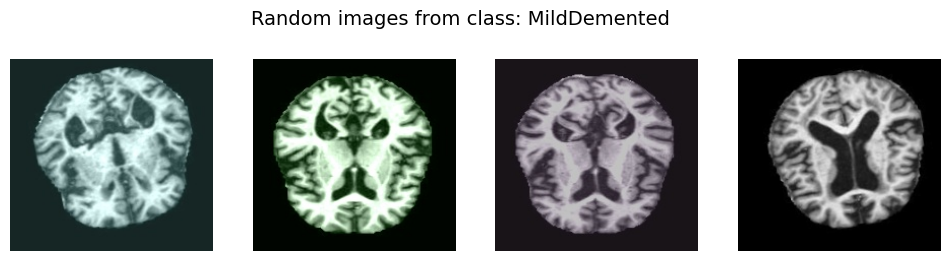

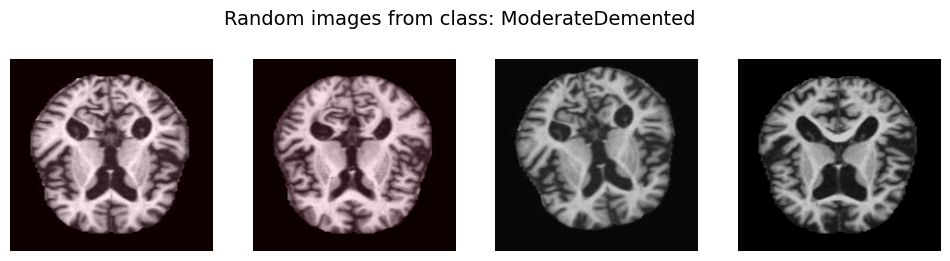

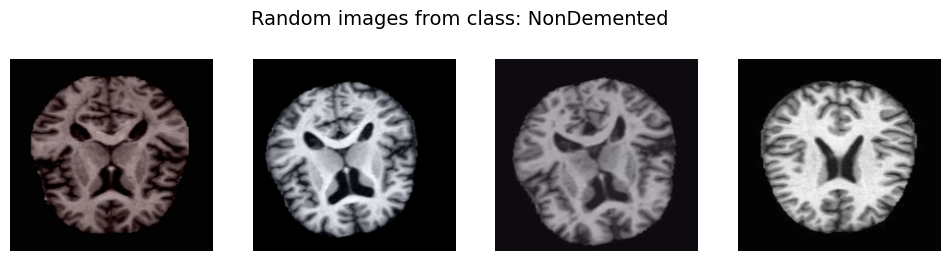

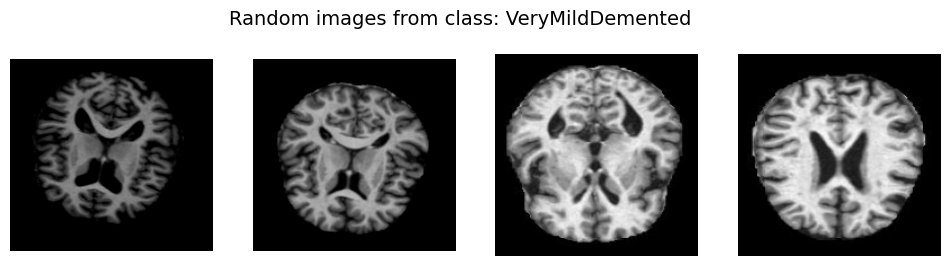

In [ ]:
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
num_images = 4

# Plot images for each class
for class_name in classes:
    class_folder = os.path.join('data/AugmentedAlzheimerDataset/', class_name)
    image_files = os.listdir(class_folder)
    random_images = random.sample(image_files, num_images)

    plt.figure(figsize=(12, 3))
    plt.suptitle(f'Random images from class: {class_name}', fontsize=14)

    for i, image_file in enumerate(random_images):
        image_path = os.path.join(class_folder, image_file)
        image = Image.open(image_path)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()

### Calcular Accuracy y Loss


In [ ]:
def test(model, loader): # funcion para calcular la precision del modelo
    num_correct = 0
    num_total = 0
    epoch_loss = 0.0
    model.eval() # ponemos el modelo en modo evaluacion
    model = model.to(device=device) # movemos el modelo al device (cpu o gpu)
    with torch.no_grad(): # deshabilitamos el calculo del gradiente (no necesita actualizar pesos)

        # xi: datos de entrada, yi: etiquetas
        for (xi, yi) in loader: # iteramos sobre los minibatches del loader de validacion o test
            xi = xi.to(device=device, dtype = torch.float32) # movemos los datos al device (cpu o gpu)
            yi = yi.to(device=device, dtype = torch.long) # movemos los datos al device (cpu o gpu)
            scores = model(xi) # mb_size, 10. corre el modelo sobre los datos de entrada
            loss =  F.cross_entropy(input=scores, target=yi)

            epoch_loss += loss.item()
            _, pred = scores.max(dim=1) #pred shape (mb_size). obtenemos la clase con mayor score (prediccion)
            # comparamos las predicciones con las etiquetas y sumamos el numero de predicciones correctas
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1).
            # sumamos 1 por cada prediccion correcta
            num_total += pred.size(0)


        loss_ = epoch_loss / len(loader)
        accuracy = float(num_correct)/num_total

        return loss_, accuracy



### Cargar modelo pre-entrenado

In [ ]:
model1 = models.densenet121(pretrained=True)

#### Exploremos el modelo

In [ ]:
for i, w in enumerate(model1.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64]) True
4 torch.Size([64]) True
5 torch.Size([128, 64, 1, 1]) True
6 torch.Size([128]) True
7 torch.Size([128]) True
8 torch.Size([32, 128, 3, 3]) True
9 torch.Size([96]) True
10 torch.Size([96]) True
11 torch.Size([128, 96, 1, 1]) True
12 torch.Size([128]) True
13 torch.Size([128]) True
14 torch.Size([32, 128, 3, 3]) True
15 torch.Size([128]) True
16 torch.Size([128]) True
17 torch.Size([128, 128, 1, 1]) True
18 torch.Size([128]) True
19 torch.Size([128]) True
20 torch.Size([32, 128, 3, 3]) True
21 torch.Size([160]) True
22 torch.Size([160]) True
23 torch.Size([128, 160, 1, 1]) True
24 torch.Size([128]) True
25 torch.Size([128]) True
26 torch.Size([32, 128, 3, 3]) True
27 torch.Size([192]) True
28 torch.Size([192]) True
29 torch.Size([128, 192, 1, 1]) True
30 torch.Size([128]) True
31 torch.Size([128]) True
32 torch.Size([32, 128, 3, 3]) True
33 torch.Size([224]) True
34 torch.Size([224]) 

In [ ]:
model1

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

#### Ajustar a nuestro modelo

Modificamos la ultima capa lineal del modelo para añadir la nuestra con las 4 salidas que necesitamos segun las clases de nuestro dataset.

Además, ponemos el resto de parametros de la red a false para que no se ajusten durante el entrenamiento.

In [ ]:
for i, parameter in enumerate(model1.parameters()):
    parameter.requires_grad = False

for param in model1.features.denseblock4.parameters():#solo los de este último bloque se ponen a True para que se modifiquen
    param.requires_grad =True

# #Se modifica la ultima capa de la red, con Dropout se desactivarán el 20% de las neuronas aleatoriamente durante cada paso del entrenamiento para que no haya sobreajuste.
# model_densenet.classifier=torch.nn.Sequential(
# torch.nn.Dropout(0.2,inplace=True),
# torch.nn.Linear(1024,4),
# )

In [ ]:
for i, parameter in enumerate(model1.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 False
109 False
110 False


### Loop de entrenamiento

#### Primer entrenamiento

In [ ]:
def train(model, optimizer, loader, lr_scheduler):

    for (xi, yi) in loader:
        model.train()
        xi = xi.to(device=device, dtype=torch.float32)
        yi = yi.to(device=device, dtype=torch.long)
        scores = model(xi)
        loss = F.cross_entropy(input= scores, target=yi)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lr_scheduler.step()

In [ ]:
lr = 0.0015
epochs = 10

model1.classifier=torch.nn.Sequential(
            torch.nn.Dropout(0.2,inplace=True),
            torch.nn.Linear(1024,4),)

optimizer = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.85)

In [ ]:
model1

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
model1 = model1.to(device=device)
best_acc = 0.0
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
lr_history = []

for epoch in range(epochs):

    train(model1, optimizer, train_loader, lr_scheduler)
    epoc_val_loss, epoc_val_accuracy = test(model1, val_loader)
    epoc_train_loss, epoc_train_accuracy = test(model1, train_loader)

    if best_acc <= epoc_train_accuracy:
        best_acc = epoc_train_accuracy
        best_model = copy.deepcopy(model1)

    train_loss_history.append(epoc_train_loss)
    train_acc_history.append(epoc_train_accuracy)
    val_loss_history.append(epoc_val_loss)
    val_acc_history.append(epoc_val_accuracy)
    lr_history.append(lr_scheduler.get_last_lr()[0])

    print(f'Epoch: {epoch} ACCURACY (validation): {epoc_val_accuracy:.4f}, ACCURACY (train): {epoc_train_accuracy:.4f},\
           LOSS (validation): {epoc_val_loss:.4f}, LOSS (train): {epoc_train_loss:.4f}')

Epoch: 0 ACCURACY (validation): 0.7609, ACCURACY (train): 0.6624,           LOSS (validation): 0.5372, LOSS (train): 0.7185
Epoch: 1 ACCURACY (validation): 0.7940, ACCURACY (train): 0.6624,           LOSS (validation): 0.4600, LOSS (train): 0.7185
Epoch: 2 ACCURACY (validation): 0.8315, ACCURACY (train): 0.6624,           LOSS (validation): 0.4144, LOSS (train): 0.7185
Epoch: 3 ACCURACY (validation): 0.8381, ACCURACY (train): 0.6624,           LOSS (validation): 0.3723, LOSS (train): 0.7185
Epoch: 4 ACCURACY (validation): 0.8698, ACCURACY (train): 0.6624,           LOSS (validation): 0.3256, LOSS (train): 0.7185
Epoch: 5 ACCURACY (validation): 0.8756, ACCURACY (train): 0.6624,           LOSS (validation): 0.2970, LOSS (train): 0.7185
Epoch: 6 ACCURACY (validation): 0.8933, ACCURACY (train): 0.6624,           LOSS (validation): 0.2544, LOSS (train): 0.7185
Epoch: 7 ACCURACY (validation): 0.9029, ACCURACY (train): 0.6624,           LOSS (validation): 0.2427, LOSS (train): 0.7185
Epoch: 8

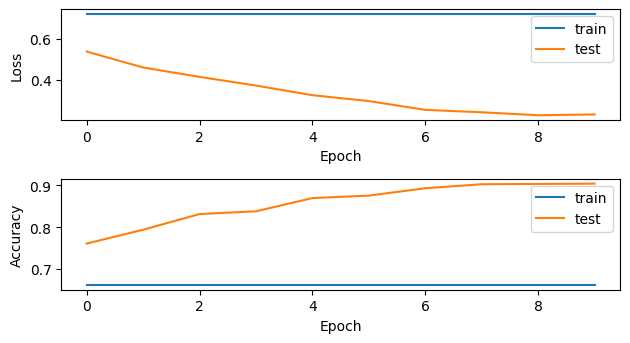

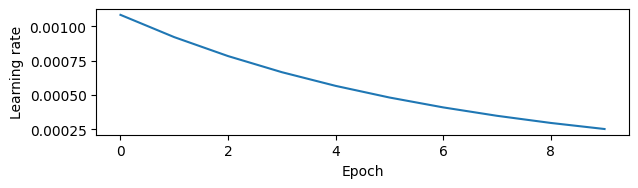

In [ ]:
# Gráfica de la evolución de la pérdida y la precisión
plt.subplot(3, 1, 1)
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(train_acc_history, label='train')
plt.plot(val_acc_history, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

plt.subplot(3, 1, 3)
plt.plot(lr_history)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.tight_layout()
plt.show()

#### Segundo entrenamiento

A continuación se ponen todos los parametros de la red a true, para realizar un segundo entrenamiento y de esta manera conseguir que la red generalice mejor.

In [ ]:
for i, parameter in enumerate(best_model.parameters()):
    parameter.requires_grad = True

In [ ]:
best_model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
best_model = best_model.to(device=device)
best_acc = 0.0
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
lr_history = []

for epoch in range(epochs):

    train(best_model, optimizer, train_loader, lr_scheduler)
    epoc_val_loss, epoc_val_accuracy = test(best_model, val_loader)
    epoc_train_loss, epoc_train_accuracy = test(best_model, train_loader)

    if best_acc <= epoc_val_accuracy:
        best_acc = epoc_val_accuracy
        best_model_2 = copy.deepcopy(best_model)

    train_loss_history.append(epoc_train_loss)
    train_acc_history.append(epoc_train_accuracy)
    val_loss_history.append(epoc_val_loss)
    val_acc_history.append(epoc_val_accuracy)
    lr_history.append(lr_scheduler.get_last_lr()[0])

    print(f'Epoch: {epoch} ACCURACY (validation): {epoc_val_accuracy:.4f}, ACCURACY (train): {epoc_train_accuracy:.4f},\
           LOSS (validation): {epoc_val_loss:.4f}, LOSS (train): {epoc_train_loss:.4f}')

In [ ]:
test_loss, test_acc = test(best_model_2, test_loader)
print(f'ACCURACY (test): {test_acc:.4f}, LOSS (test): {test_loss:.4f}')

Practicamos la inferencia sobre el modelo final.

In [ ]:
def prueba_modelo(modelo):
    modelo.eval()
    rnd_sample_idx = np.random.randint(len(test_loader))
    xi = test_loader.dataset[rnd_sample_idx][0]
    yi = test_loader.dataset[rnd_sample_idx][1]
    xi = xi.to(device=device, dtype = torch.float32) # movemos los datos al device (cpu o gpu)
    image = test_loader.dataset[rnd_sample_idx][0]
    image = (image - image.min()) / (image.max() -image.min() )

    scores = modelo(xi.unsqueeze(0))
    _, pred = scores.max(dim=1)
    image_for_display = np.transpose(image, (1, 2, 0))

    plt.imshow(image_for_display)
    plt.title(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
    plt.suptitle(f'Clase predicha: {classes[pred]}')
    plt.show()

In [ ]:
prueba_modelo(best_model_2)

### Guardar modelo

In [ ]:
torch.save(best_model_2.state_dict(), 'checkpoint.pth')

Volver a cargar el modelo.



In [ ]:
model1.load_state_dict(torch.load('checkpoint.pth',map_location=torch.device('cpu')))


In [ ]:
prueba_modelo(model1)